# Conformal Prediction with Vector-Valued Score Functions

Conformal Prediction (CP) provides a way to quantify uncertainty in machine learning by constructing prediction sets based on conformity scores. While standard CP methods rely on univariate scores, extending them to multivariate settings is challenging due to the absence of a natural ordering for vectors. This tutorial introduces **Optimal Transport Conformal Prediction (OTCP)**, a method that leverages optimal transport to rank multivariate scores while preserving coverage guarantees. We will explore the fundamentals of CP, the challenges of multivariate extensions, and how OTCP provides a principled solution with practical applications in regression and classification tasks.
For a sequence of observed data and a new input point:

$$
D_n = \{(x_1, y_1), ..., (x_n, y_n)\} \text{ and } x_{n+1},
$$

the objective is to construct a set that contains the unobserved response $y_{n+1}$ with a specified confidence level $100(1- \alpha)\%$.

This involves evaluating scores $S(x, y, \hat y)\in\mathbb{R}$ such as the prediction error of a model $\hat y$, for each observation $(x, y)$ in $D_n$ and ranking these score values. The conformal prediction set for the new input $x_{n+1}$ is the collection of all possible responses $y$ whose score $S(x_{n+1}, y, \hat y)$ ranks small enough to meet the prescribed confidence threshold, compared to the scores $S(x_i, y_i, \hat y)$ in the observed data.
By design, CP requires the notion of order, as the inclusion of a candidate response depends on its relative ranking to the scores observed previously. Hence, the classical strategies developed so far largely target score functions with univariate outputs. This limits their applicability to multivariate responses, as ranking multivariate scores $S(x, y, \hat y) \in \mathbb{R}^d, d\geq 2$ is not as straightforward as ranking univariate scores in $\mathbb{R}$. We leverage optimal transport to overcome this issue.

Leveraging Optimal Transport for Ranking:
We suppose that $\mathbb{P}$ is only available through finite samples and consider the *discrete* transport map:

$$
T : (Z_i)_{i \in [n+1]} \to (U_i)_{i \in [n+1]}
$$

which can be obtained by solving the optimal assignment problem, which seeks to minimize the total transport cost between the empirical distributions $\mathbb{P}_{n+1}$ and $\mathbb{U}_{n+1}$.

## Optimal Transport Merging for Conformal Scores

We introduce optimal transport merging, a procedure that reduces any vector-valued score $S(x, y) \in \mathbb{R}^d$ to a suitable 1D score using OT. We redefine the non-conformity score function of an observation as:

$$
S_{\rm{OT-CP}}(x, y) =  \|T^\star \circ S(x, y)\|
$$

where $T^\star$ is the optimal transport map that pushes the distribution of vector-valued scores onto a uniform ball distribution $\mathbb{U}$ of the same dimension.
This approach ultimately relies on the natural ordering of the real line, making it possible to directly apply one-dimensional conformal prediction methods to the sequence of transformed scores:

$$
Z_i = \|S_{\rm{OT-CP}}(X_i, Y_i)\| \text{ for } i \in [n+1] .
$$


Optimal Transport Conformal Prediction (OTCP) provides a way to extend CP to multivariate settings by leveraging optimal transport to define a meaningful ranking of multivariate scores. This method can be applied in various regression and classification tasks where multivariate outputs are involved, ensuring coverage guarantees while preserving interpretability.
In this tutorials, we will dive into practical implementations and code examples to illustrate how OTCP can be applied to real-world machine learning problems.


## Data Generation
To demonstrate OTCP, we generate synthetic data using a Gaussian Mixture Model (GMM). This allows us to simulate complex distributions where responses  are drawn from multiple clusters, conditioned on input features .
The Gaussian Mixture Model is parameterized by:

 - Weights: Probabilities assigned to each mixture component.

 - Means: Cluster centers in .

 - Covariances: Spread of each component in .

We define these as functions of $X$ to simulate conditional distributions.

In [565]:
from shapely.geometry import Polygon

import numpy as np
from scipy.spatial import Delaunay
from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt


def w_fn(X):
    return np.array([3 / 8, 3 / 8, 1 / 4])


def mu_fn(X):
    scale = np.log(np.linalg.norm(X, axis=0) + 1e-10)
    scale = 1
    return scale * np.array([[-3, 0], [3, 0], [0, -5 / 2]])


def cov_fn(X):
    return np.array([[[5, -4], [-4, 5]], [[5, 4], [4, 5]], [[4, 0], [0, 1]]])


def sample_conditional_gmm(weights, means, covs, n_samples):
    component_indices = np.random.choice(
        len(weights), size=n_samples, p=weights
    )
    y = np.array(
        [
            multivariate_normal.rvs(mean=means[k], cov=covs[k])
            for k in component_indices
        ]
    )
    return y, component_indices


class Oracle:
    def __init__(self, w_fn, mu_fn, cov_fn):
        self.w_fn = w_fn
        self.mu_fn = mu_fn
        self.cov_fn = cov_fn

    def fit(self, X, y):
        self.weights_ = self.w_fn(X)
        self.means_ = self.mu_fn(X)
        self.covariances_ = self.cov_fn(X)
        self.y = y

    def predict(self, X):

        n_samples = X.shape[0]
        n_components = len(self.weights_)

        log_probs = np.zeros((n_samples, n_components))
        for k in range(n_components):
            log_probs[:, k] = np.log(
                self.weights_[k]
            ) + multivariate_normal.logpdf(
                self.y, mean=self.means_[k], cov=self.covariances_[k]
            )
        return np.argmax(log_probs, axis=1)

## Visualization of Data

oracle generation


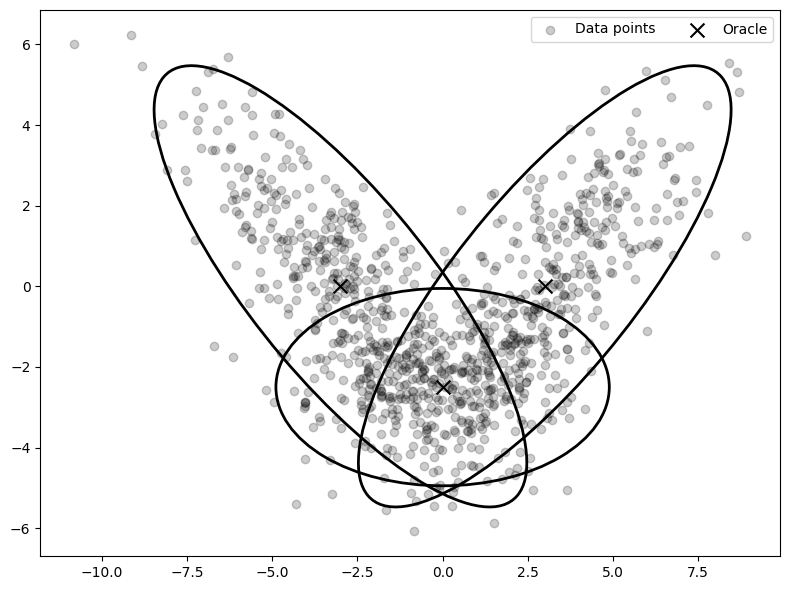

In [566]:
# np.random.seed(42)
# Generate the synthetic data
n_samples = 1000
n_features = 2
alpha = 0.2
ord = 2


X_full = np.random.randn(n_samples, n_features)

oracle = Oracle(w_fn, mu_fn, cov_fn)
oracle.fit(X_full, None)
weights = oracle.weights_
means = oracle.means_
covs = oracle.covariances_

y_full, components = sample_conditional_gmm(weights, means, covs, n_samples)
oracle.y = y_full
print("oracle generation")


def plot_ellipses(means, covariances, label, color, alpha=None):

    if alpha is None:
        alpha = 0.2 if label == "Oracle" else 1

    for i in range(len(means)):
        label = label if i == 0 else None

        eigenvalues, eigenvectors = np.linalg.eigh(covariances[i])
        angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
        width, height = 2 * np.sqrt(5.991 * eigenvalues)
        ellipse = plt.matplotlib.patches.Ellipse(
            means[i],
            width,
            height,
            angle=angle,
            edgecolor=color,
            facecolor="none",
            linewidth=2,
            alpha=alpha,
        )
        plt.gca().add_patch(ellipse)
        plt.scatter(
            means[i, 0],
            means[i, 1],
            c=color,
            s=100,
            marker="x",
            label=label,
            alpha=alpha,
        )


y_plot = y_full

plt.figure(figsize=(8, 6))
plt.scatter(y_plot[:, 0], y_plot[:, 1], c="k", alpha=0.2, label="Data points")
plot_ellipses(oracle.means_, oracle.covariances_, "Oracle", "k", alpha=1)
plt.tight_layout()
plt.legend(ncols=3)
plt.show()

In [567]:
# Use the package alpha_shape instead?
from shapely.geometry import LineString, MultiPoint, Polygon
from shapely.ops import polygonize


def alpha_shape(points, alpha=1.5):
    """
    Computes the alpha shape (concave hull) of a set of points.

    :param points: List of (x, y) coordinates.
    :param alpha: Alpha parameter (smaller → tighter boundary).
    :return: Shapely Polygon representing the boundary.
    """
    if len(points) < 4:
        return MultiPoint(points).convex_hull

    tri = Delaunay(points)
    edges = set()

    def circumradius(a, b, c):
        """Calculate the circumradius of a triangle given its three vertices."""
        A = np.linalg.norm(b - c)
        B = np.linalg.norm(a - c)
        C = np.linalg.norm(a - b)
        s = (A + B + C) / 2
        area = (
            max(s * (s - A) * (s - B) * (s - C), 1e-10) ** 0.5
        )  # Avoid division by zero
        return (A * B * C) / (4.0 * area)

    edge_count = {}
    for simplex in tri.simplices:
        a, b, c = points[simplex]
        if circumradius(a, b, c) < alpha:
            for i, j in zip(simplex, np.roll(simplex, 1)):
                edge = tuple(sorted([i, j]))
                edge_count[edge] = edge_count.get(edge, 0) + 1

    # Keep only the edges that appear once (boundary edges)
    boundary_edges = [edge for edge, count in edge_count.items() if count == 1]
    # Convert edges to coordinate pairs
    edge_coords = [
        LineString([points[i], points[j]]) for i, j in boundary_edges
    ]
    # Create a valid polygon from edges
    boundary = list(polygonize(edge_coords))
    if boundary:
        boundary = max(
            boundary, key=lambda p: p.area
        )  # Take the largest polygon
    else:
        boundary = MultiPoint(points).convex_hull

    return boundary


def plot_uqset(points, label, color, alpha=0.8):

    boundary = alpha_shape(points, alpha=alpha)
    if isinstance(boundary, Polygon) and boundary.is_valid:
        x, y = boundary.exterior.xy
        plt.plot(x, y, label=label, color=color)

# Gaussian Mixture as base prediction model

In [568]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split

X_train, X_rest, y_train, y_rest = train_test_split(
    X_full, y_full, test_size=0.4, random_state=1
)
X_calib, X_test, y_calib, y_test = train_test_split(
    X_rest, y_rest, test_size=0.1, random_state=1
)

candidates = y_full + np.random.normal(scale=0.1, size=y_full.shape)
idx_target = 0

n_components = 3
model = GaussianMixture(
    n_components=n_components
)  # , weights_init=oracle.weights_, means_init=oracle.means_)
model.fit(y_train)

GaussianMixture(n_components=3)

To learn the transport map, we define the source points as the score functions 
$$
Z_i = y_i - \hat y(x_i)
$$

and for the target points (we are free to choose any reference distribution)
$$
U_i \sim \mathcal{N}(0, \Sigma)
$$

Define source and target to learn the transport map


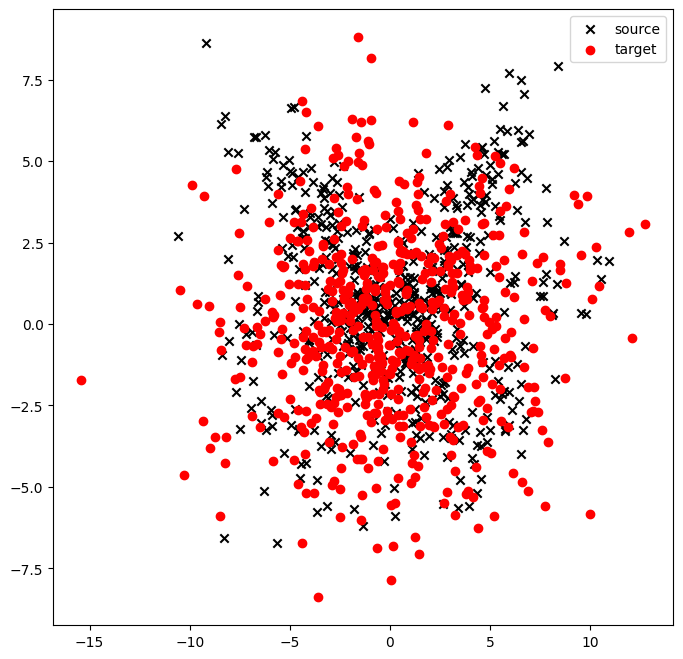

In [569]:
print("Define source and target to learn the transport map")
y_labels_pred = model.predict(X_train)
residual_train = y_train - model.means_[y_labels_pred]
source = residual_train
cov_target = np.cov(residual_train.T)
target = np.random.multivariate_normal(
    mean=[0, 0], cov=cov_target, size=source.shape[0]
)

fig = plt.figure(figsize=(8, 8))
plt.scatter(source[:, 0], source[:, 1], c="k", label="source", marker="x")
plt.scatter(target[:, 0], target[:, 1], c="r", label="target")
plt.legend()
plt.show()

# Computing the optimal transport map

We will first detail all the steps to obtain the conformal prediction set and then show how to leverage our package for fast computation

In [570]:
import jax
import jax.numpy as jnp
import numpy as np
import scipy.special as ss
from scipy.stats import qmc

import seaborn as sns

from ott.geometry import pointcloud
from ott.problems.linear import potentials
from ott.solvers import linear

jax.config.update("jax_enable_x64", True)


def entropic_map(source, target, eps=1e-1):
    geom = pointcloud.PointCloud(source, target, epsilon=eps)
    out = linear.solve(geom)
    dp = out.to_dual_potentials()
    return dp


tmap = entropic_map(source, target)
tmap = tmap.transport

In [571]:
# residual on calibration data
y_labels_pred = model.predict(X_calib)
residual = y_calib - model.means_[y_labels_pred]

# Compute target pred
y_labels_target = model.predict(X_test[idx_target].reshape(1, -1))
target_pred = model.means_[y_labels_target]

In [572]:
print("compute radius OT on calibration data")
alpha = 0.1
scores = np.linalg.norm(tmap(residual), axis=-1, ord=ord)
r_alpha = np.quantile(scores, 1 - alpha)
r_otcp = r_alpha
nn_cf = np.linalg.norm(tmap(candidates - target_pred), axis=-1, ord=ord)
otcp_points = candidates[nn_cf <= r_alpha]
print(r_alpha)

compute radius OT on calibration data
7.734220694705664


In [573]:
# n_points = 300
# n_points = candidates.shape[0]
# plt.stem(nn_cf[:n_points])
# plt.hlines(r_alpha, 0, n_points, color="k")
# plt.show()

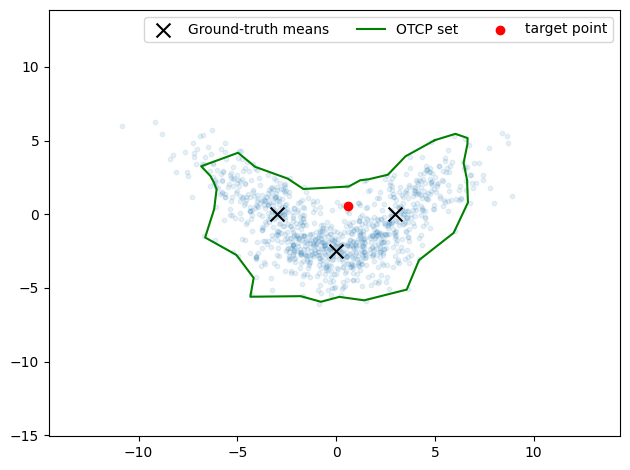

In [579]:
fig, ax = plt.subplots()
y_plot = y_full
plt.scatter(y_plot[:, 0], y_plot[:, 1], s=10, alpha=0.1)
plt.scatter(
    oracle.means_[:, 0],
    oracle.means_[:, 1],
    c="k",
    marker="x",
    s=100,
    label="Ground-truth means",
)
# plt.scatter(otcp_points[:, 0], otcp_points[:, 1], c="g", alpha=0.01, label="OTCP points")
plot_uqset(otcp_points, "OTCP set", "g", alpha=2)
plt.scatter(
    y_plot[idx_target, 0], y_plot[idx_target, 0], label="target point", c="r"
)

shift = 5 * y_full.std()
# samples.max(axis=0)  # TODO compute a better shift
mean = y_plot.mean(axis=0)
ax.set_xlim(mean[0] - shift, mean[0] + shift)
ax.set_ylim(mean[1] - shift, mean[1] + shift)
plt.tight_layout()
plt.legend(ncol=3)
name = "banana_n_component_" + str(n_components)
plt.savefig(name, format="png")
plt.show()